In [11]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
import matplotlib
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_names,plot_reg_path_ax_lambdasearch_customcolors_tslasso
import copy

In [12]:
print('Getting embeddings')
n_components = 2
b = 49
d = 2
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta = np.pi / 4,xvar = 0., rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  


Getting embeddings


In [13]:
nreps = 1
nsel = 100 
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates = {}
for r in range(nreps):
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p',
                                   replicates[r].dg_x_normalized, 
                                   replicates[r].tangent_bases_M)
    replicates[r].results = get_sr_lambda_parallel(np.asarray([np.identity(d) for i in range(nsel)]), replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)
    replicates[r].get_ordered_axes()


initializing lambda search
converged 9.999825360925673
0 4.999912680462836 probe
converged 4.999912680462836
we did it [0 1]


In [15]:
m = 2

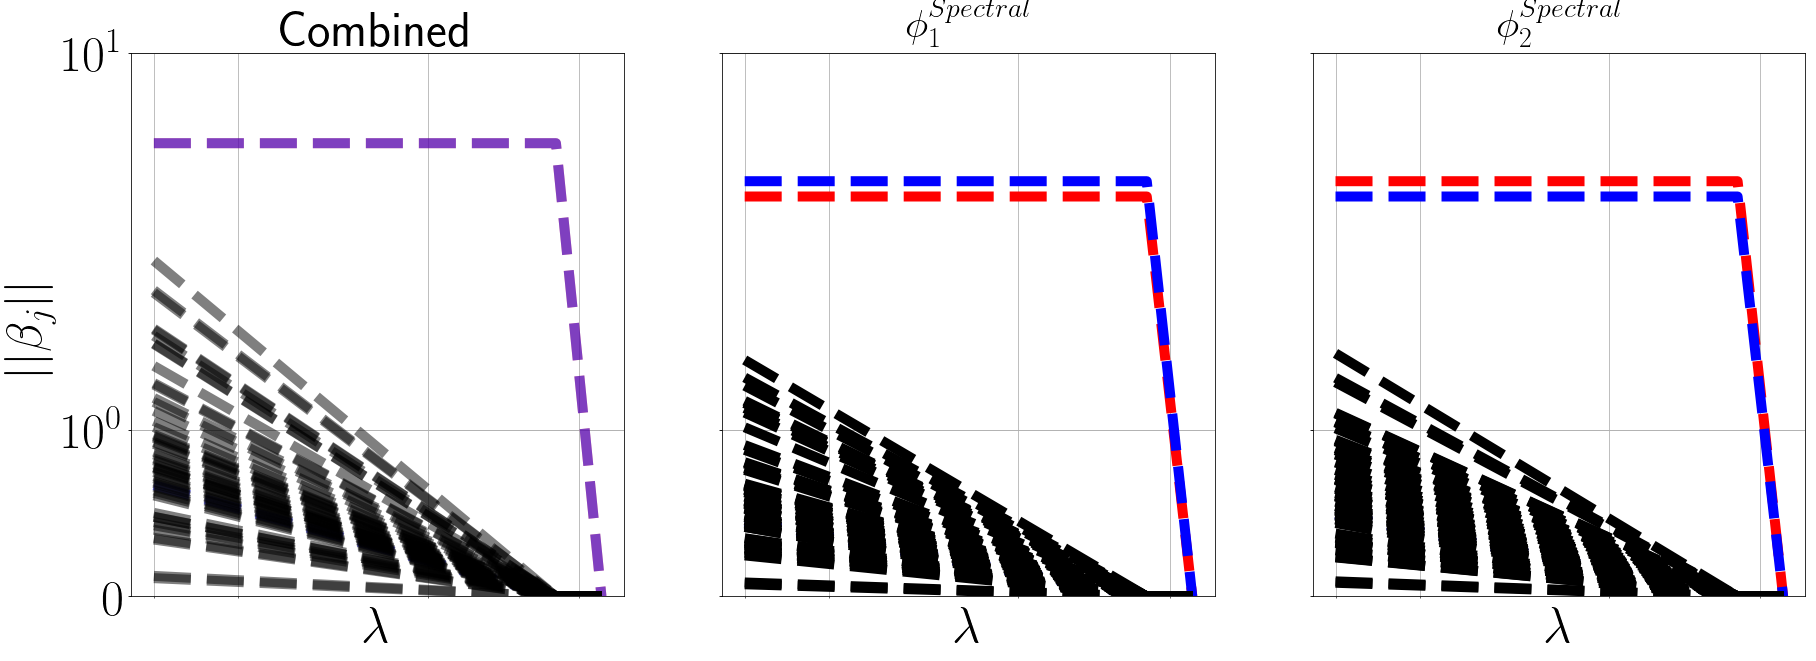

In [16]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
colors_all = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',48)])
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder  * np.sqrt(m*n) , fig,colors_all, names)
#plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/spectral_flasso', bbox_inches = "tight")




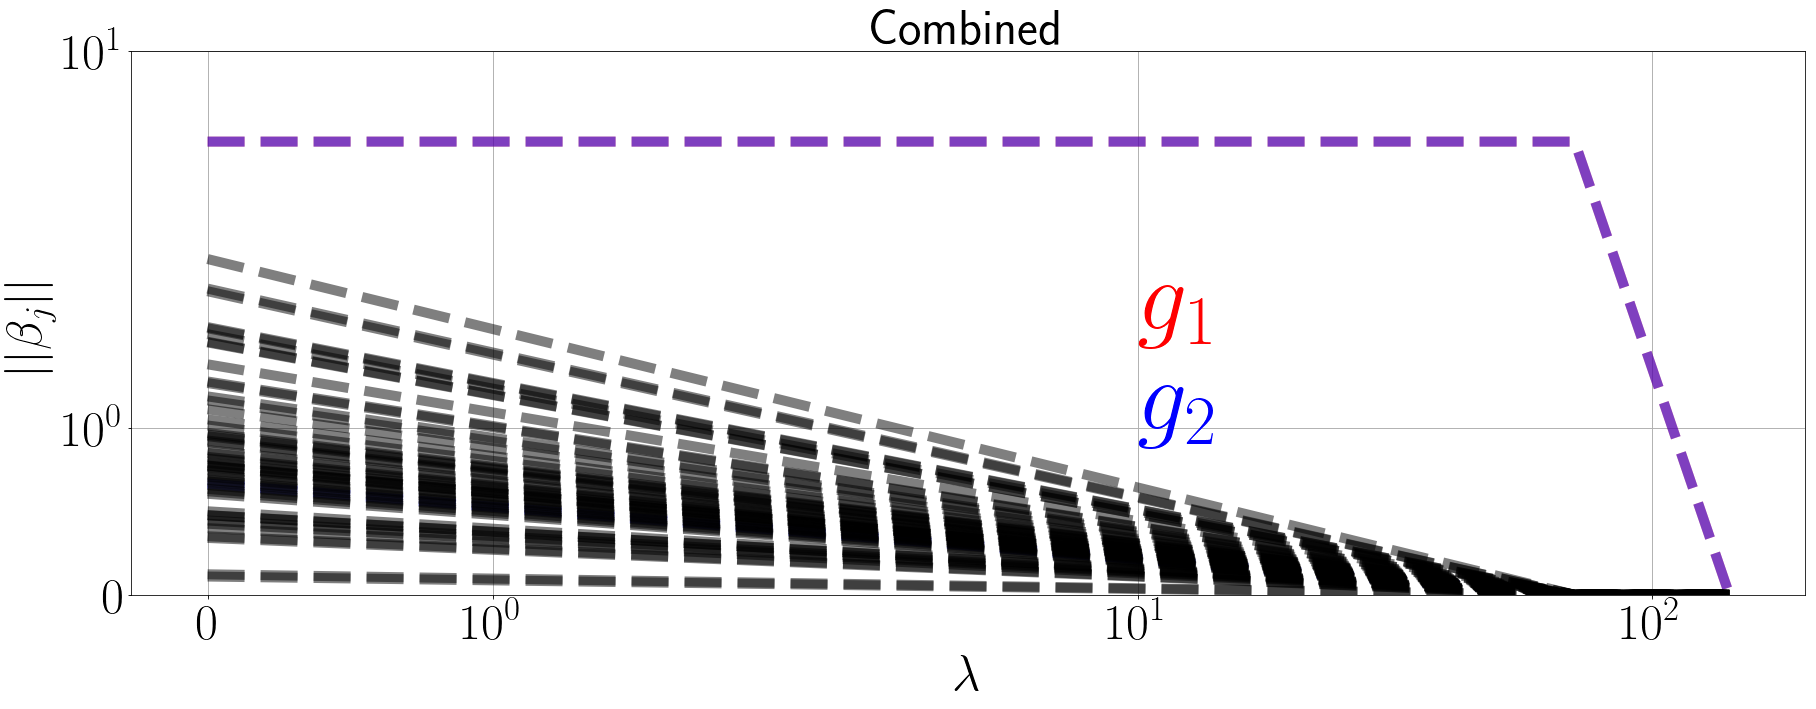

In [17]:
%matplotlib inline
n = 100
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(figsize=(30,10) )
colors_all = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',48)])
names = []#[r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_tslasso(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder  * np.sqrt(d*n) , fig,colors_all, names)
axes_all.text(10,1.5,r"$g_1$", color = 'red', fontdict = {"fontsize":100})
axes_all.text(10,.9,r"$g_2$", color = 'blue', fontdict = {"fontsize":100})
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/tslasso/swissroll/tslasso', bbox_inches = "tight")


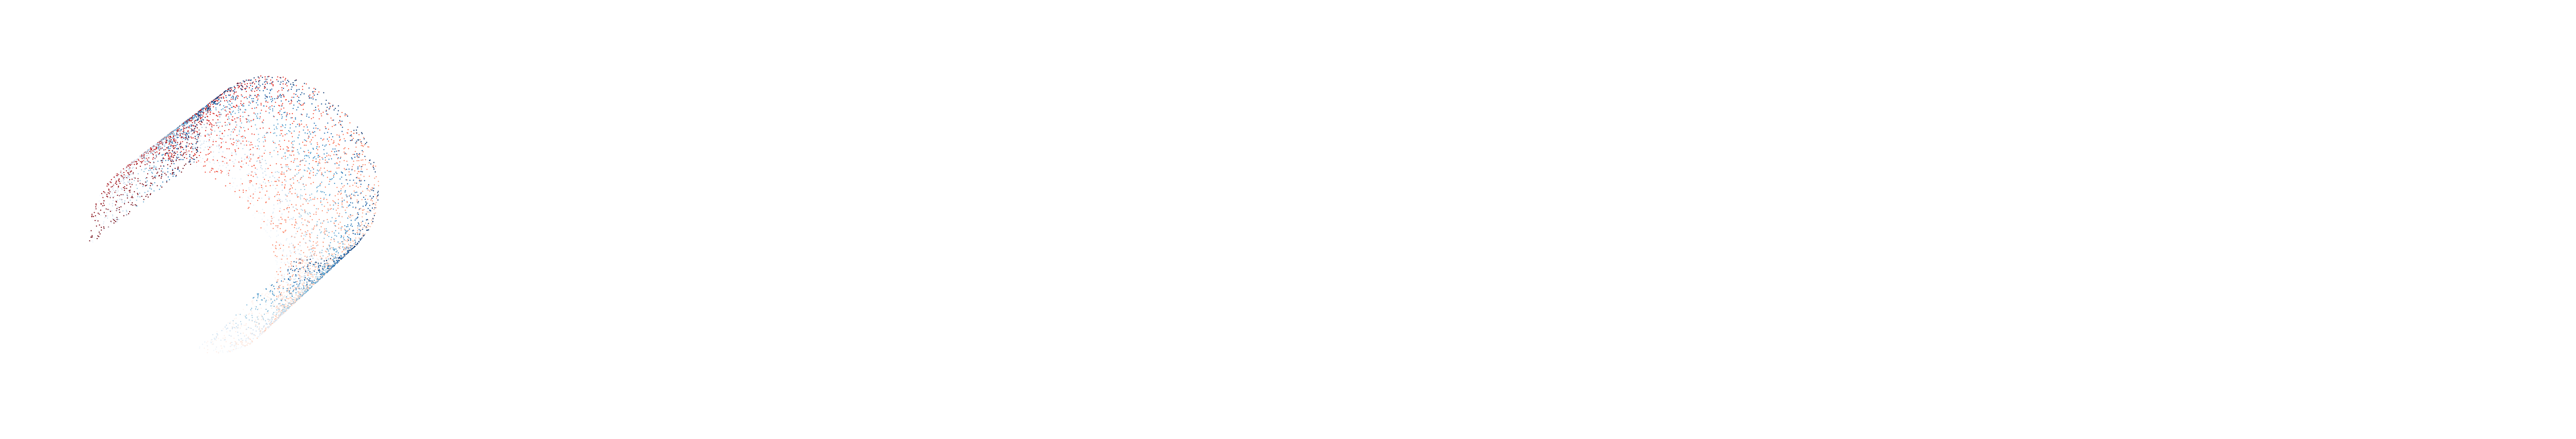

In [10]:
%matplotlib inline
unr = data @ rotator.transpose()
data_plot = unr[:,:3]

fig, axes_all = plt.subplots(figsize=(15,15))
axes_all.set_axis_off()
alpha = .05
ax = fig.add_subplot(1,1,1, projection='3d')
x = data_plot[:, 0]
y = data_plot[:, 1]
z = data_plot[:, 2]
s = 5
alpha = 1.
inds1  = list(range(2500))
inds2 = np.asarray(list(range(2500))) + 2500
ax.scatter(x[inds1], y[inds1], z[inds1], s=s, alpha=alpha, marker='.', c = ts[inds1], cmap = 'Reds')
ax.scatter(x[inds2], y[inds2], z[inds2], s=s, alpha=alpha, marker='.', c = ys[inds2], cmap = 'Blues')
ax.set_axis_off()
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/tslasso/swissroll/unrotated', bbox_inches = "tight")
